# Zero-shot operon prediction tutorial

This tutorial outlines how one can use genome embeddings from pretrained Bacformer combined with other data to predict whether pairs of contiguous genes are in the same operon.

We provide a dataset obtained by running long-read RNA sequencing on 5 distinct strains and show how to embed the genomes with Bacformer and use the resulting embeddings combined with information on `intergenic distance (bp)` and `strand` to predict whether the two genes are in the same operon.

Before you start, make sure to have the [bacformer](https://github.com/macwiatrak/Bacformer) package installed.

## Step 1: Import required dependencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from bacformer.pp import embed_dataset_col
from bacformer.tl import (
    get_intergenic_bp_dist,
    operon_prot_indices_to_pairwise_labels,
    predict_pairwise_operon_boundaries,
)
from datasets import load_dataset
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve


/Users/jaygut/Documents/Side_Projects/Bacformer/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2: Load the dataset

Load the dataset from HuggingFace. The dataset consists of protein sequences and operon annotations extracted
by running long-read RNA sequencing.

In [2]:
# load the dataset
dataset = load_dataset("macwiatrak/operon-identification-long-read-rna-sequencing", split="test")

Generating test split: 100%|██████████| 5/5 [00:00<00:00, 76.61 examples/s]


## Step 3: Compute Bacformer embeddings

Convert the protein sequences to genome embeddings. This is done in 2 steps:
1. Embed the protein sequences with the base pLM model which is [ESM-2 t12 35M](https://huggingface.co/facebook/esm2_t12_35M_UR50D).
2. Use the protein embeddings as input to the Bacformer model which computes contextual protein embeddings and takes the average of them to get genome embedding.

This step takes a few min max on a single A100 NVIDIA GPU.

In [3]:
# embed the protein sequences with Bacformer and convert to pandas
df = embed_dataset_col(
    dataset=dataset,
    model_path="macwiatrak/bacformer-masked-complete-genomes",
    model_type="bacformer",
    max_n_proteins=9000,
    genome_pooling_method=None,
).to_pandas()

A new version of the following files was downloaded from https://huggingface.co/macwiatrak/bacformer-masked-complete-genomes:
- configuration_bacformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/macwiatrak/bacformer-masked-complete-genomes:
- utils_bacformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/macwiatrak/bacformer-masked-complete-genomes:
- modeling_bacformer.py
- utils_bacformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Some weights of EsmModel were not initialized from the model checkpoint at fa

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   strain_name          5 non-null      object
 1   contig_name          5 non-null      object
 2   gene_name            5 non-null      object
 3   locus_tag            5 non-null      object
 4   start                5 non-null      object
 5   end                  5 non-null      object
 6   strand               5 non-null      object
 7   protein_id           5 non-null      object
 8   operon_prot_indices  5 non-null      object
 9   embeddings           5 non-null      object
dtypes: object(10)
memory usage: 532.0+ bytes


## Step 4: Postprocessing

Perform postprocessing, computing pairwise labels, intergenic bp distance.

In [30]:
# explode the dataset by contig, this allows prediction per contig
df = df.explode(
    [
        "contig_name",
        "gene_name",
        "locus_tag",
        "start",
        "end",
        "strand",
        "protein_id",
        "embeddings",
        "operon_prot_indices",
    ]
)

# compute the intergenic distances
df["intergenic_bp"] = df.apply(
    lambda row: get_intergenic_bp_dist(
        starts=row["start"],
        ends=row["end"],
    ),
    axis=1,
)

# get the labels
df["operon_pairwise_labels"] = df.apply(
    lambda row: operon_prot_indices_to_pairwise_labels(
        operon_prot_indices=row["operon_prot_indices"],
        n_genes=len(row["embeddings"]),
    ),
    axis=1,
)

## Step 5: Perform operon prediction

Using (1) Bacformer embeddings, (2) intergenic distance (bp) and (3) gene strand information, perform operon prediction
for pairs of contiguous genes. The result is a score between two genes, with high score implying high probability
of the two genes being in the same operon.

For more details on how we perform the prediction see `bacformer.tl.operon_prediction.predict_pairwise_operon_boundaries`.

In [44]:
# run the operon prediction
df["operon_pairwise_scores"] = df.apply(
    lambda row: predict_pairwise_operon_boundaries(
        emb=np.stack(row["embeddings"]),
        intergenic_bp=row["intergenic_bp"],
        strand=row["strand"],
        scale_bp=500,
        max_gap=500,
    ),
    axis=1,
)

## Step 6: Plot the results

Plot the AUROC curves per contig.

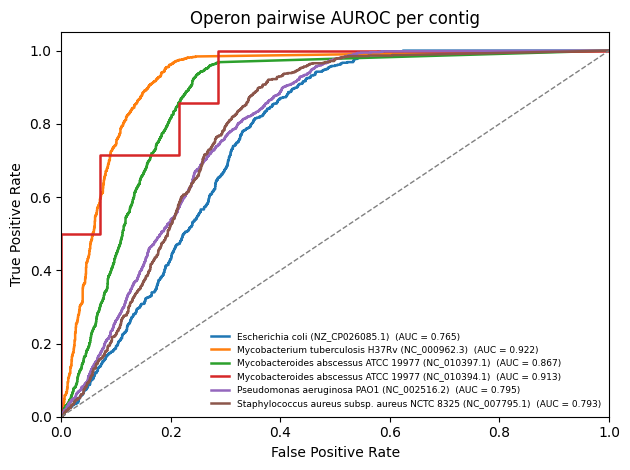

In [48]:
# get contig label combining strain name and contig name
df['contig_label'] = df.apply(lambda row: f"{row.strain_name} ({row.contig_name})", axis=1)

# plot AUROC curves
for _, row in df.iterrows():
    y_true  = row["operon_pairwise_labels"]
    y_score = row["operon_pairwise_scores"]
    contig  = row["contig_label"]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc     = auc(fpr, tpr)

    plt.plot(fpr, tpr,
             lw=1.8,
             label=f"{contig}  (AUC = {roc_auc:.3f})")

# -----------------------------------------------------------
# 2)  Plot formatting
# -----------------------------------------------------------
plt.plot([0, 1], [0, 1], linestyle="--", color="grey", lw=1)   # chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Operon pairwise AUROC per contig")
plt.legend(loc="lower right", fontsize=6.5, frameon=False)
plt.tight_layout()
plt.show()

----------------------

#### Voilà, you made it 👏! 

In case of any issues or questions raise an issue on github - https://github.com/macwiatrak/Bacformer/issues.